# US Federal Public Debt, Annual Receipts, Budget Deficit, and Interest Payments on Public Debt
This notebook examines the evolution of US federal public debt as a percentage of GDP, its share of annual federal receipts, and the annual budget deficit relative to GDP. Wherever possible, I make use of data series with quarterly frequencies and annual amounts provided by [FRED](https://fred.stlouisfed.org). Annual amounts can be calculated in two ways: 1) by using a quarterly seasonally adjusted amount and extrapolating it to an annual equavallent, or 2) taking the sum of the trailing four quarters or the trailing twelve months. In this notebook I rely predominantely on the first approach with interest outlays being the only exception when I use the second. All dollar amounts are in millions of USD.

In all time series and graphs, the reading for the start of the quarter designates the amount for the end of the quarter. I.e. total federal debt of $28,859,125 mln for 2024-10-01 designates the amount for the end of the quarter that started on 2024-10-01.

It's not sufficient to just look at the size of the public debt. While the size of public debt may appear prodigious, understanding its true burden requires deeper examination.

1. Since public debt is predominantly serviced through tax revenue, which depends on GDP, examining the debt-to-GDP and debt-to-tax-revenue ratios is essential. As you will see below, both are slowly inching higher. For tax revenue, I use the sum of Personal current taxes, Taxes on production and imports, Taxes on corporate income, and Taxes from the rest of the world.
2. The costs of servicing it to GDP. Despite the growing debt, the ratio of interest outlays to GDP is still below the levels of the 80s but is quickly rising, it is also above the average of 2.03% calculated since 1969. It exceeded 3\% of GDP for the first time in the 21<sup>st</sup> century.
3. The cause of increases in the debt &mdash; the public deficit &mdash; and what percentage of GDP it takes.
4. It's representation in _real_ USD values. The majority of statements about the US Federal debt talk about its nominal value, however the recent bout of inflation has been conducive to shrinking its real value. I look at it at the very end of the notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

from treasury_data import monthly_treasury_statement

In [2]:
report_start = date.fromisoformat('1969-01-01')
report_end = date.today()

In [3]:
# Human readable column names for DataFrames
FEDERAL_DEBT = 'Federal Debt'
FEDERAL_DEBT_TO_GDP = 'Federal Debt, as % of GDP'
FEDERAL_TAX_REVENUE = 'Federal Annual Receipts'
FEDERAL_DEBT_TO_TAX = 'Federal Debt, as % of Annual Receipts'
FEDERAL_BUDGET_DEFICIT = 'Federal Budget Deficit'
FEDERAL_DEFICIT_TO_GDP = 'Federal Deficit, as % of GDP'
FEDERAL_DEBT_INTEREST = 'Federal Debt Annual Interest Outlays'
FEDERAL_DEBT_INTEREST_TO_GDP = 'Federal Debt Interest Outlays, as % of GDP'

### Federal Debt and Total Receipts
There are five relevant dataseries provided by [FRED](https://fred.stlouisfed.org) that could potentially be used:
* `GFDEBTN` &mdash; Federal Debt: Total Public Debt in millions (quarterly frequency). This series accounts for both federal debt held by the public as well as US intragovernmental debt.
* `W018RC1Q027SBEA` &mdash; Federal government total receipts in billions (quarterly frequency, seasonally adjusted annual rate). It comprises taxes, contributions for government social insurance, and other federal government revenues.
* `GFDEGDQ188S` &mdash; Federal Debt: Total Public Debt as Percent of Gross Domestic Product (quarterly frequency, seasonally adjusted). Like `GFDEBTN` this series accounts for both federal debt held by the public as well as intragovernmental debt.
* `FYGFDPUN` &mdash; unlike `GFDEBTN` this series accounts only for federal debt held by the public in millions (quarterly frequency).
* `FYGFGDQ188S` &mdash; unlike `GFDEGDQ188S` this series accounts only for federal debt held by the public as percent of GDP (quarterly frequency).

In this notebook I look at the public portion of US federal debt `FYGFDPUN` rather than its total amount `GFDEBTN` (i.e. I exclude the part the government owns to itself). If you want to include it, please replace `FYGFDPUN` with `GFDEBTN` and `FYGFGDQ188S` with `GFDEGDQ188S`. It is more accurate to use the public portion of the US debt for analysis as the part captured by the Intragovernmental Holdings Debt (IGHD) is but an instrument to balance liquidity in the US federal budget system (it's, however, taken into acount when determining the US debt ceiling).

In [4]:
# GFDEBTN         -- Federal Debt: Total Public Debt in millions (quarterly frequency)
# W006RC1Q027SBEA -- Federal government current tax receipts in billions (quarterly frequency, seasonally adjusted)
# GFDEGDQ188S     -- Federal Debt: Total Public Debt as Percent of Gross Domestic Product (quarterly frequency)
fred_pub_debt_and_tax_rev = web.get_data_fred(['FYGFDPUN', 'W018RC1Q027SBEA', 'FYGFGDQ188S'],
                                              start=report_start, end=report_end)

# Converting current tax receipts to millions
fred_pub_debt_and_tax_rev.W018RC1Q027SBEA *= 1000 

# Converting to a decimal fraction
fred_pub_debt_and_tax_rev.FYGFGDQ188S /= 100

# In case you prefer to use NA000327Q instead of W006RC1Q027SBEA
# Converting current tax recepits from quarterly to annual (trailing 4 quarters)
# fred_pub_debt_and_tax_rev.NA000327Q = fred_pub_debt_and_tax_rev.NA000327Q.rolling(4).sum()

# Adding as a new column in the main DataFrame for Federal Debt to Annual Receipts Ratio
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX] = fred_pub_debt_and_tax_rev.FYGFDPUN / fred_pub_debt_and_tax_rev.W018RC1Q027SBEA

###  Interest Payments on Federal Public Debt
The only useful dataseries provided by [FRED](https://fred.stlouisfed.org) is:
* `FYOINT` &mdash; Federal Outlays: Interest in millions (annual frequency). Unfortunately it's only available
with annual frequencies. So I need to upsample it into quarterly frequencies and deal with the change in
fiscal year ends starting from 1977 (from end of June in prior years to end of September from 1977 onwards). As a result a correct number for ratios involving interest outlays is available only for the third quarter of each year.
* `GDP` &mdash; Gross Domestic Product in billions (quarterly frequency, from 1930, seasonally adjusted annual rate). This series lets me calculate annual interest outlays to GDP ratio with a frequency of every quarter.

To compensate for the fact that FRED only provides data on the money the U.S. Treasury spends on interest payments on US public debt, I created my own `treasury_data.monthly_treasury_statement` module for analyzing [Monthly Treasury Statements](https://fiscaldata.treasury.gov/datasets/monthly-treasury-statement/summary-of-receipts-outlays-and-the-deficit-surplus-of-the-u-s-government) that US Treasury creates every month. My module works directly with [the US Treasury API ](https://fiscaldata.treasury.gov/api-documentation/). Unfortunately the API only serves data starting from March 2015. Therefore I use a combination of data provided by FRED's `FYOUINT` series and that from the US Treasury API to cover the full range of years.

In [5]:
# FYOINT -- Federal Outlays: Interest in millions (annual frequency)
interest_payments = web.get_data_fred('FYOINT', start=report_start, end=report_end)
gdp = web.get_data_fred('GDP', start=report_start, end=report_end)

# Converting to Series, adjusting units from billions to millions, and making frequencies explicit 
gdp = gdp.GDP * 1000
gdp = gdp.asfreq('QS')

# In years up to 1976 fiscal year end was end of June, in the years thereafter
# end of September. This needs to be properly accounted for when upsampling into quarter frequency.
interest_payments_A_JUN = interest_payments[:'1976'].asfreq('YE-JUN')
interest_payments_A_SEP = interest_payments['1977':].asfreq('YE-SEP')

interest_payments_QS = interest_payments_A_JUN.resample('QS').bfill(limit=4).FYOINT
interest_payments_QS_from_1977 = interest_payments_A_SEP.resample('QS').bfill(limit=4).FYOINT

# Add 4 missing quarters with missing quarters for backfilling
missing_quarters = pd.Series(np.nan, index=pd.date_range("1976-07-01", periods=4, freq="QS"))
interest_payments_QS_from_1977 = pd.concat([missing_quarters, interest_payments_QS_from_1977]).bfill(limit=4)
interest_payments_QS = pd.concat([interest_payments_QS, interest_payments_QS_from_1977])

# Augment with more precise data from the Treasury API
mts = monthly_treasury_statement.MTS(report_start, report_end)
net_interest = mts.retrieve_net_interest()

# Exclude the last month(s) if the last month is not a quarter end
if not net_interest.index[-1].is_quarter_end:
    net_interest = net_interest.loc[:net_interest.index[-1] - pd.offsets.QuarterEnd(1)]

# Convert into quarterly frequencies and millions of USD
net_interest = net_interest.resample('QS').sum() / 1e6

# Convert into an annual rate
net_interest = net_interest.rolling(4).sum().dropna()

interest_payments_QS.update(net_interest)
missing_quarters_idx = net_interest.index.difference(interest_payments_QS.index)
interest_payments_QS = pd.concat([interest_payments_QS, net_interest.loc[missing_quarters_idx]])

# Typically GDP data is updated earlier than other series captured in the 'fred_pub_debt_and_tax_rev' dataframe.
# This piece of code ensures we don't miss the newer datapoints.
mx = max(gdp.index[0], fred_pub_debt_and_tax_rev.index[0])
diff = gdp.loc[mx:].index.symmetric_difference(fred_pub_debt_and_tax_rev.loc[mx:].index)
if not diff.empty:
    fred_pub_debt_and_tax_rev = fred_pub_debt_and_tax_rev.reindex(index=fred_pub_debt_and_tax_rev.index.union(diff))

# Adding as a new column in the main DataFrame for interest payments on public debt
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST] = interest_payments_QS
# Adding as a new column in the main DataFrame for nterest payments on public debt to Annual Tax Revenue Ratio
fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST_TO_GDP] = interest_payments_QS / gdp

# Best guess for the last year
# fred_pub_debt_and_tax_rev.ffill(limit=3, inplace=True)

### Federal Budget Deficit and Budget Deficit to GDP
There are a few relevant dataseries provided by [FRED](https://fred.stlouisfed.org) that could potentially be used:
* `M318501Q027NBEA` &mdash; Federal government budget surplus in billions (quarterly frequency, from 1957, not seasonally adjusted). Unfortunately it is not frequently updated and lacks the last quarters
* `MTSDS133FMS` &mdash; Federal Surplus or Deficit in millions (monthly frequency, from 1980, not seasonally adjusted). This one contains the most recent months.

In this notebook I use `M318501Q027NBEA` as the basis. I extend it with the most recent quarters by appropriately resampling MTSDS133FMS. Since federal budget has predominantly featured deficit lately, I convert surpluses into deficits — i.e. a positive amount designates a deficit, while a negative denotes a surplus. Since national debt ratios are typically annualized, I resample it to return annual budget deficits using the sum of the trailing 4 quarters. This way I get a new annual budget deficit for every quarter comprising the most recent 4 quarters. Using the sum of the trailing four quarters also compensates for using a non-seasonally adjusted data for federal budget deficit, which is handy when caculating the budget deficit to GDP ratio.

Using the `GDP` series, I calculate the annual budget deficit to GDP ratio on a quarterly basis.

In [6]:
# M318501Q027NBEA -- Federal government budget surplus in billions (quarterly frequency, from 1957)
# MTSDS133FMS     -- Federal Surplus or Deficit in millions (monthly frequency, from 1980)

# Actually, MTSDS133FMS tracks surpluses, but I'll convert it to deficits
fed_budget_deficit_monthly = web.get_data_fred('MTSDS133FMS', start=report_start, end=report_end)
fed_budget_deficit_quarterly = web.get_data_fred('M318501Q027NBEA', start=report_start, end=report_end)

# Convert from DataFrames to Series, converting budget surpluses to deficits,
# and adjusting units from billions to millions where appropriate
fed_budget_deficit_monthly = fed_budget_deficit_monthly.MTSDS133FMS * -1
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.M318501Q027NBEA * -1000

# Making frequencies explicit
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.asfreq('QS')
fed_budget_deficit_monthly = fed_budget_deficit_monthly.asfreq('MS')

# Aligning frequencies
fed_budget_deficit_quarterly_from_fy_1981Q1 = fed_budget_deficit_monthly.resample('QS').sum()

# Extending M318501Q027NBEA with new quarterly data
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.combine_first(fed_budget_deficit_quarterly_from_fy_1981Q1)

# Converting quarterly budget deficit into annual (trailing 4 quarters)
fed_budget_deficit_quarterly = fed_budget_deficit_quarterly.rolling(4).sum()

# Adding as a new column in the main DataFrame for budget deficits
fred_pub_debt_and_tax_rev[FEDERAL_BUDGET_DEFICIT] = fed_budget_deficit_quarterly

# Adding as a new column in the main DataFrame for deficit to gdp
fred_pub_debt_and_tax_rev[FEDERAL_DEFICIT_TO_GDP] = (fed_budget_deficit_quarterly / gdp).ffill()

# Truncating to start of calendar year 1970
fred_pub_debt_and_tax_rev = fred_pub_debt_and_tax_rev.loc['1970':]

### Preparing factors for conversion from nominal to real amounts using the GDP Implicit Price Deflator

In [7]:
nom_2_real_conv_factors = web.get_data_fred('GDPDEF', start=report_start, end=report_end)

nom_2_real_conv_factors['conv_factor'] = nom_2_real_conv_factors.GDPDEF.iloc[-1] / nom_2_real_conv_factors.GDPDEF

# Convert into pandas.Series
nom_2_real_conv_factors = nom_2_real_conv_factors.conv_factor

### Visualization of prepared data

In [8]:
fred_pub_debt_and_tax_rev.rename(
    columns={'GFDEBTN': FEDERAL_DEBT, 'W018RC1Q027SBEA': FEDERAL_TAX_REVENUE,
             'GFDEGDQ188S': FEDERAL_DEBT_TO_GDP,
             'FYGFDPUN': FEDERAL_DEBT, 'FYGFGDQ188S': FEDERAL_DEBT_TO_GDP},
    inplace=True)
pd.options.display.float_format = lambda x: '{:.3%}'.format(x) if x < 900 else '${:,.0f}mn'.format(x)

In [9]:
fred_pub_debt_and_tax_rev

,Federal Debt,Federal Annual Receipts,"Federal Debt, as % of GDP","Federal Debt, as % of Annual Receipts",Federal Debt Annual Interest Outlays,"Federal Debt Interest Outlays, as % of GDP",Federal Budget Deficit,"Federal Deficit, as % of GDP"
DATE,,,,,,,,
1970-01-01,"$280,814mn","$190,156mn",26.714%,147.676%,"$14,380mn",1.368%,-396700.000%,-0.377%
1970-04-01,"$274,924mn","$191,128mn",25.757%,143.843%,"$14,380mn",1.347%,"$2,845mn",0.267%
1970-07-01,"$282,367mn","$187,370mn",25.999%,150.700%,"$14,841mn",1.367%,"$8,143mn",0.750%
1970-10-01,"$291,242mn","$186,584mn",26.754%,156.092%,"$14,841mn",1.363%,"$11,381mn",1.045%
1971-01-01,"$292,043mn","$191,318mn",25.727%,152.648%,"$14,841mn",1.307%,"$16,115mn",1.420%
...,...,...,...,...,...,...,...,...
2024-07-01,"$28,325,715mn","$5,256,387mn",95.981%,538.882%,"$881,651mn",2.987%,"$1,830,751mn",6.203%
2024-10-01,"$28,859,125mn","$5,351,237mn",96.761%,539.298%,"$907,588mn",3.043%,"$2,034,016mn",6.820%
2025-01-01,"$28,932,974mn","$5,432,677mn",96.308%,532.573%,"$941,544mn",3.134%,"$2,075,116mn",6.907%


#### US Federal Annual Tax Revenue and Budget Deficit from 1990
Throughout the rest of this notebook budget deficits are displayed as positive numbers, while surpluses as negative ones.

In [10]:
TOTAL_DEBT_GRAPH_TITLE = 'US Federal Public Debt, Annual Receipts, Annual Budget Deficit, and Annual Interest Outlays'
TAXREV_DEFICIT_TITLE = 'US Annual Receipts and Budget Deficit'
LEFT_Y_AXIS_LABEL = 'Billions of USD'
INTOUTLAYS_TITLE = 'US Annual Interest Outlays'

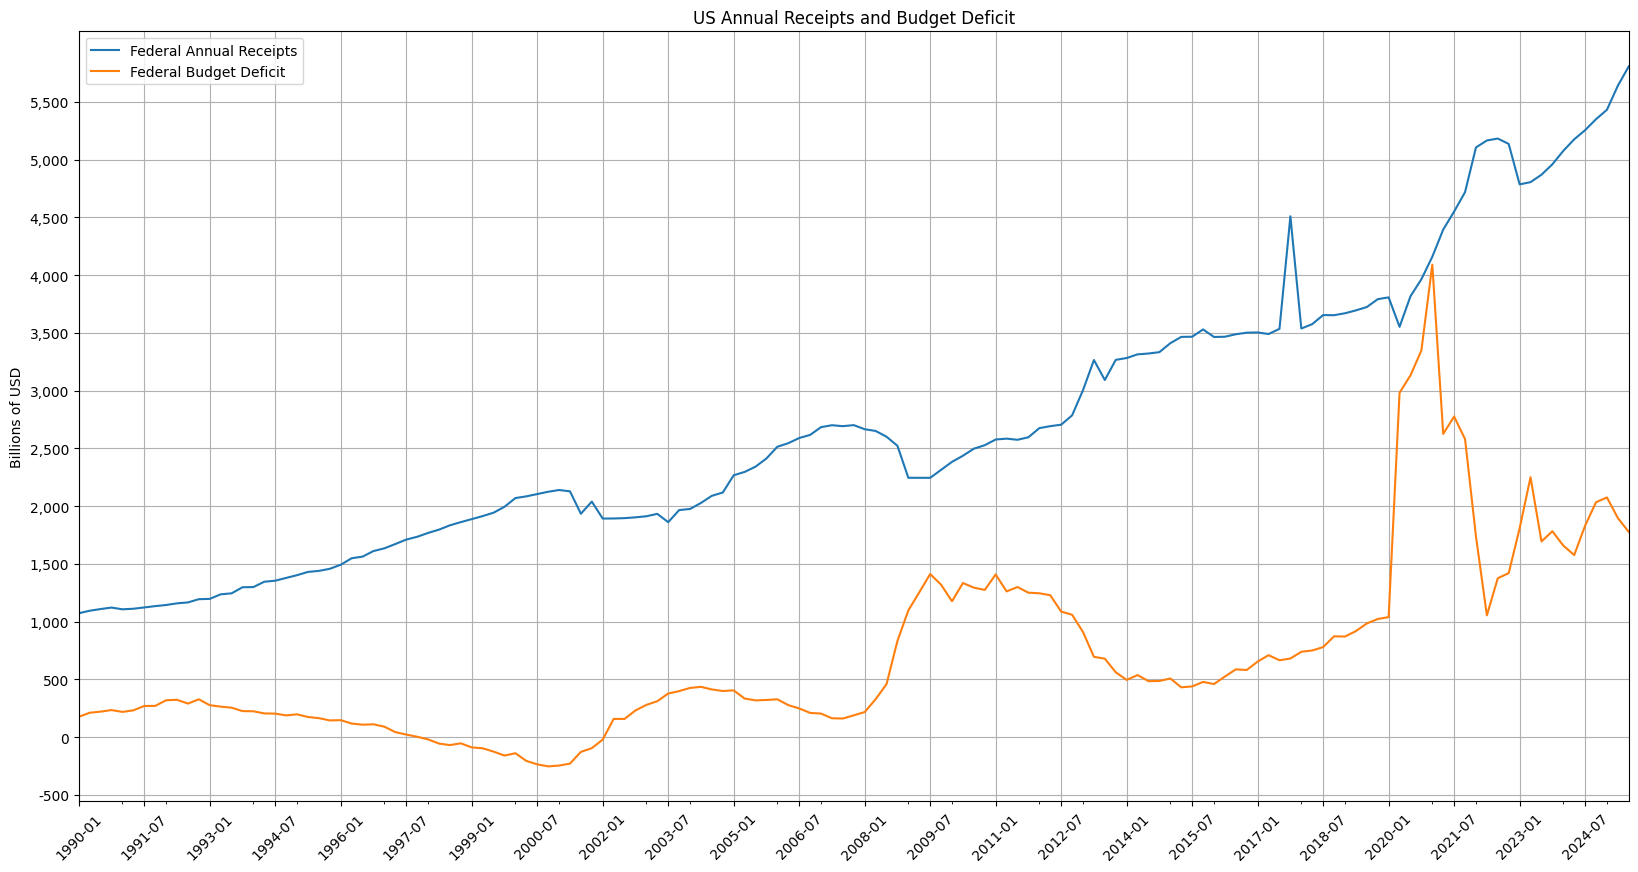

In [11]:
shorter_series = fred_pub_debt_and_tax_rev.loc['1990':, [FEDERAL_TAX_REVENUE, FEDERAL_BUDGET_DEFICIT]]
y_max = int(shorter_series.max().max())
y_step = 500000
y_max += y_step - y_max % y_step
ax = shorter_series.plot(figsize=(20,10), grid=True, yticks=range(-500000, y_max, y_step),
                     title=TAXREV_DEFICIT_TITLE, ylabel=LEFT_Y_AXIS_LABEL,
                     xticks=shorter_series.index[::6], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

#### Interest outlays on US Public Debt
The data series in the graph below is presented at an annual frequency until 2015, and at a quarterly frequency thereafter.

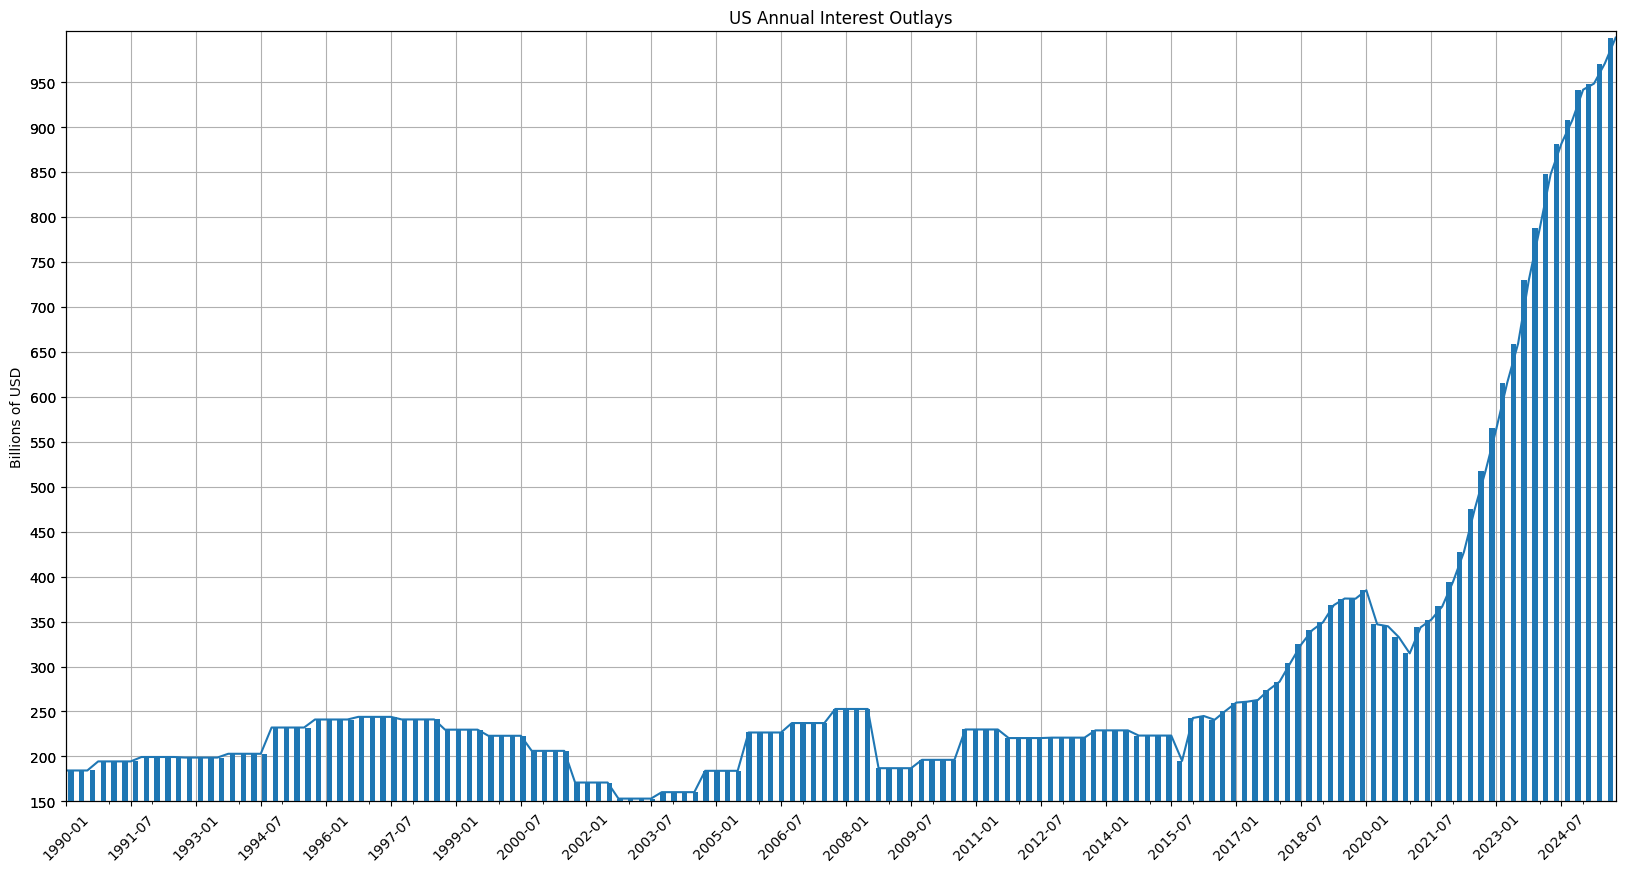

In [12]:
shorter_series = interest_payments_QS.loc['1990':]
y_max = int(shorter_series.max())
ax = shorter_series.plot(figsize=(20,10), grid=True, yticks=range(150000, y_max, 50000),
                         ylim=(150000, y_max+7000),
                         title=INTOUTLAYS_TITLE, ylabel=LEFT_Y_AXIS_LABEL,
                         xticks=shorter_series.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
shorter_series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

#### Average interest paid on the Marketable securities portion of US Public Debt

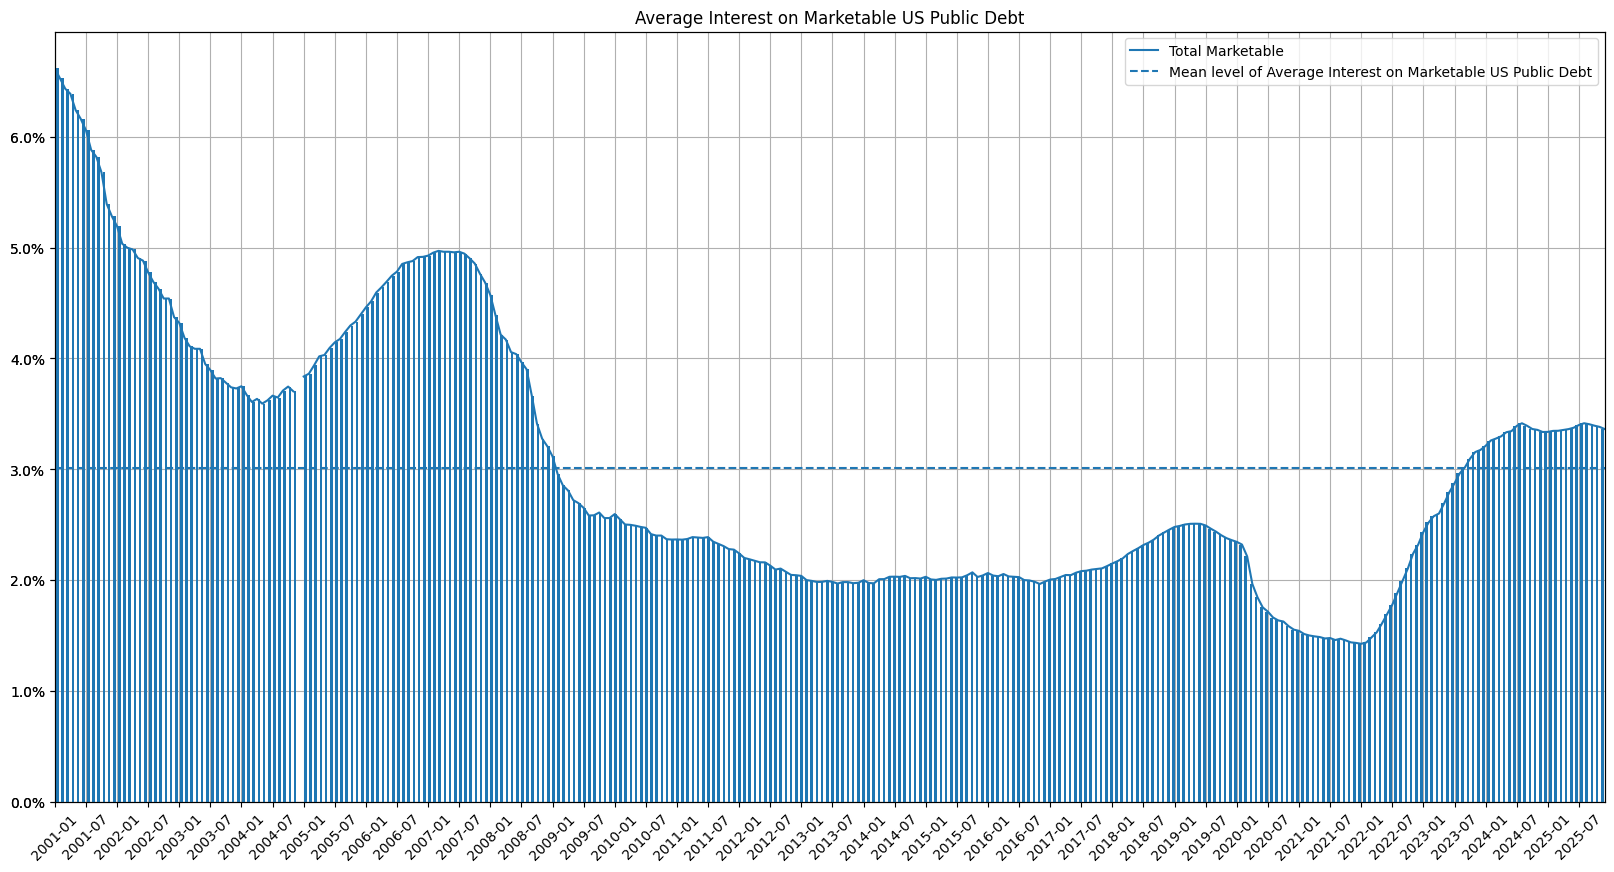

In [13]:
avg_interest = mts.retrieve_avg_interest(monthly_treasury_statement.MarketableSecurityType.TOTAL_MARKETABLE).resample('MS').last()
ax = avg_interest.plot(figsize=(20,10), grid=True, title='Average Interest on Marketable US Public Debt',
                       xticks=avg_interest.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
avg_interest.plot.bar(ax=ax2, xlabel='', legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.axhline(y=avg_interest.mean(), c='#1f77b4', ls='--', label='Mean level of Average Interest on Marketable US Public Debt')
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, avg_interest.index[::6])))

In [14]:
print(f'Average interest paid since {avg_interest.index[0]:%Y-%m-%d}: {avg_interest.mean():.2f}%')
print(f'Current interest paid: {avg_interest.iloc[-1]:.2f}%')

Average interest paid since 2001-01-01: 3.01%
Current interest paid: 3.36%


#### US Federal Public Debt to GDP, Federal Debt to Annual Receipts, Annual Federal Deficit to GDP, and Annual Interest Outlays to GDP ratios

In [15]:
DEBT_RATIOS_GRAPH_TITLE = '10 Year Treasury Yield, US Federal Public Debt to GDP, Debt to Annual Receipts, and Annual Federal Deficit to GDP ratios'
DEBT_RATIOS_GRAPH_TITLE_1 = 'US Federal Public Debt to GDP and Debt to Annual Receipts'
DEBT_RATIOS_GRAPH_TITLE_1_1 = 'US Federal Public Debt to GDP'
DEBT_RATIOS_GRAPH_TITLE_1_2 = 'US Federal Public Debt to Annual Receipts'
DEBT_RATIOS_GRAPH_TITLE_2 = '10 Year Treasury Yield and Annual Federal Deficit to GDP ratios'
DEBT_RATIOS_GRAPH_TITLE_3 = 'Interest Outlays, as % of GDP'
DEBT_RATIOS_GRAPH_TITLE_4 = 'Annual Federal Deficit to GDP'
DEBT_RATIOS_GRAPH_TITLE_5 = 'Interest Outlays, as % of Receipts'
LEFT_Y_AXIS_LABEL2 = 'Federal Debt to GDP, Federal Debt to Annual Receipts'
RIGHT_Y_AXIS_LABEL = '10 Year Treasury Yield, Annual Federal Deficit to GDP, Annual Interest Outlay to Receipts'
DEBT_RATIOS_GRAPH_TITLE_SHORT = '10 Year Treasury Yield, Annual Federal Deficit to GDP, and Federal Debt Interest Outlays to Receipts ratios'
LABEL_DEBT_TO_GDP = 'Mean level of Federal Public Debt to GDP'
LABEL_DEBT_TO_TAX = 'Mean level of Federal Public Debt to Annual Receipts'
LABEL_INT_OUTLAYS_TO_TAX_REV = 'Mean level of Interest Outlays to Receipts'
LABEL_BUDGET_DEFICIT_TO_GDP = 'Mean level of Federal Deficit to GDP'
LABEL_INTEREST_OUTLAYS_TO_GDP = 'Mean level of Federal Debt Interest Outlays to GDP'
FEDERAL_DEBT_IN_REAL_VALUES = 'US Federal Public Debt in Nominal and Real Amounts'
IN_USD_FORMATER = ' in {:%Y-%m} USD'

#### US Total Federal Public Debt to GDP and Federal Debt to Receipts ratios

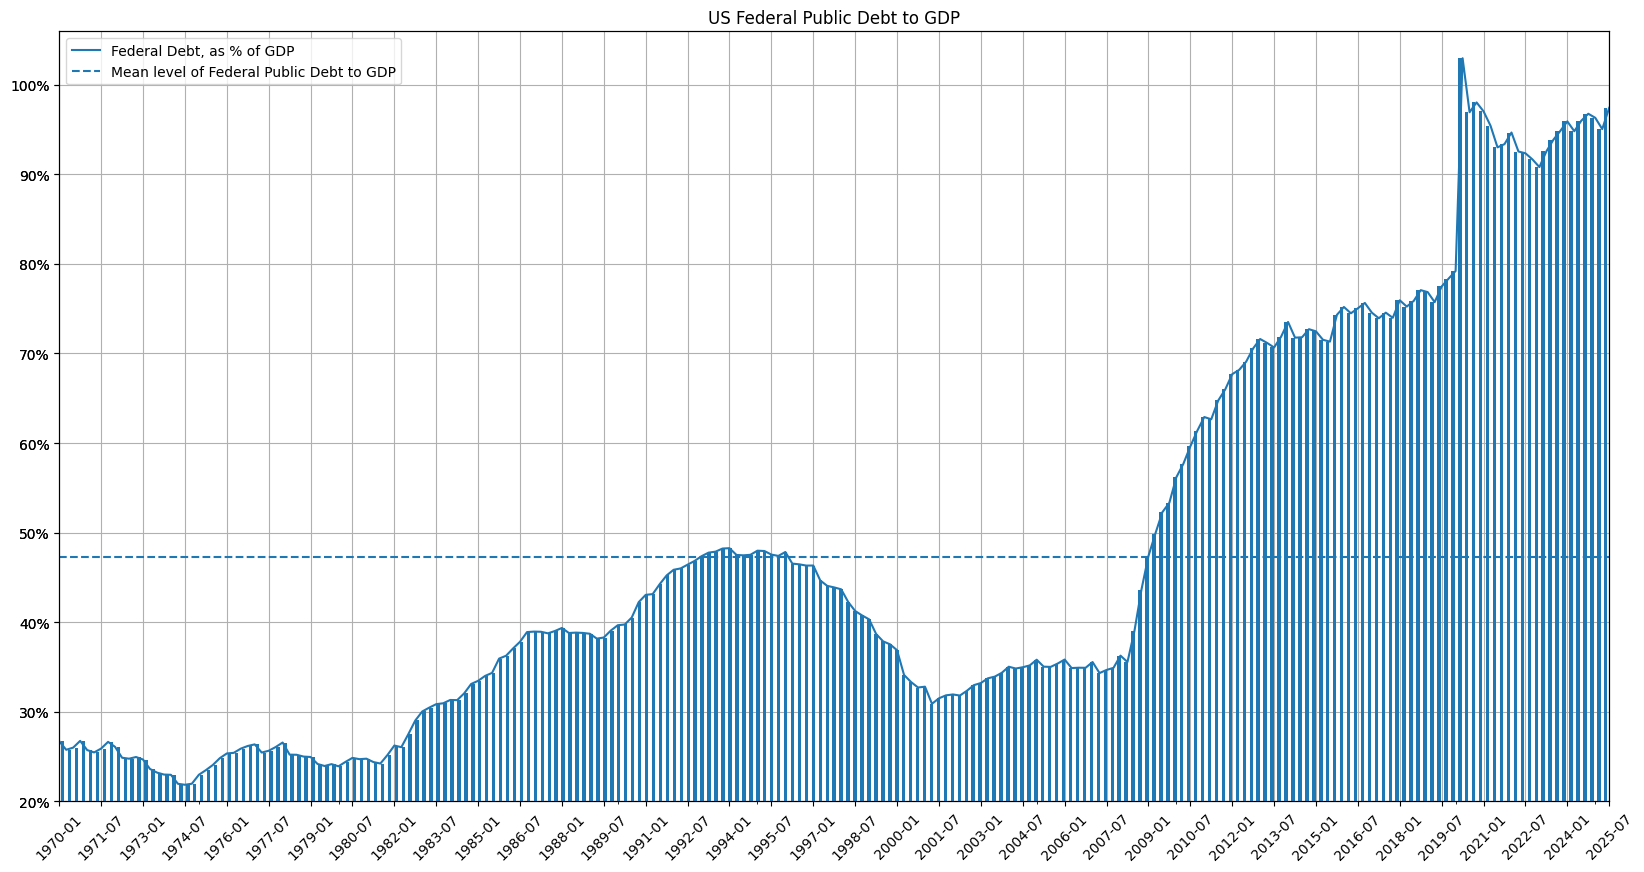

In [16]:
series = fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_GDP].dropna()
ax = series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_1_1, xticks=series.index[::6], xlabel='',
                 rot=45, yticks=np.arange(.2, 1.1, .1), ylim=(.2, series.max() + .03))
ax2 = ax.twiny()
series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=series.mean(), c='#1f77b4', ls='--', label=LABEL_DEBT_TO_GDP)
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, series.index[::6])))

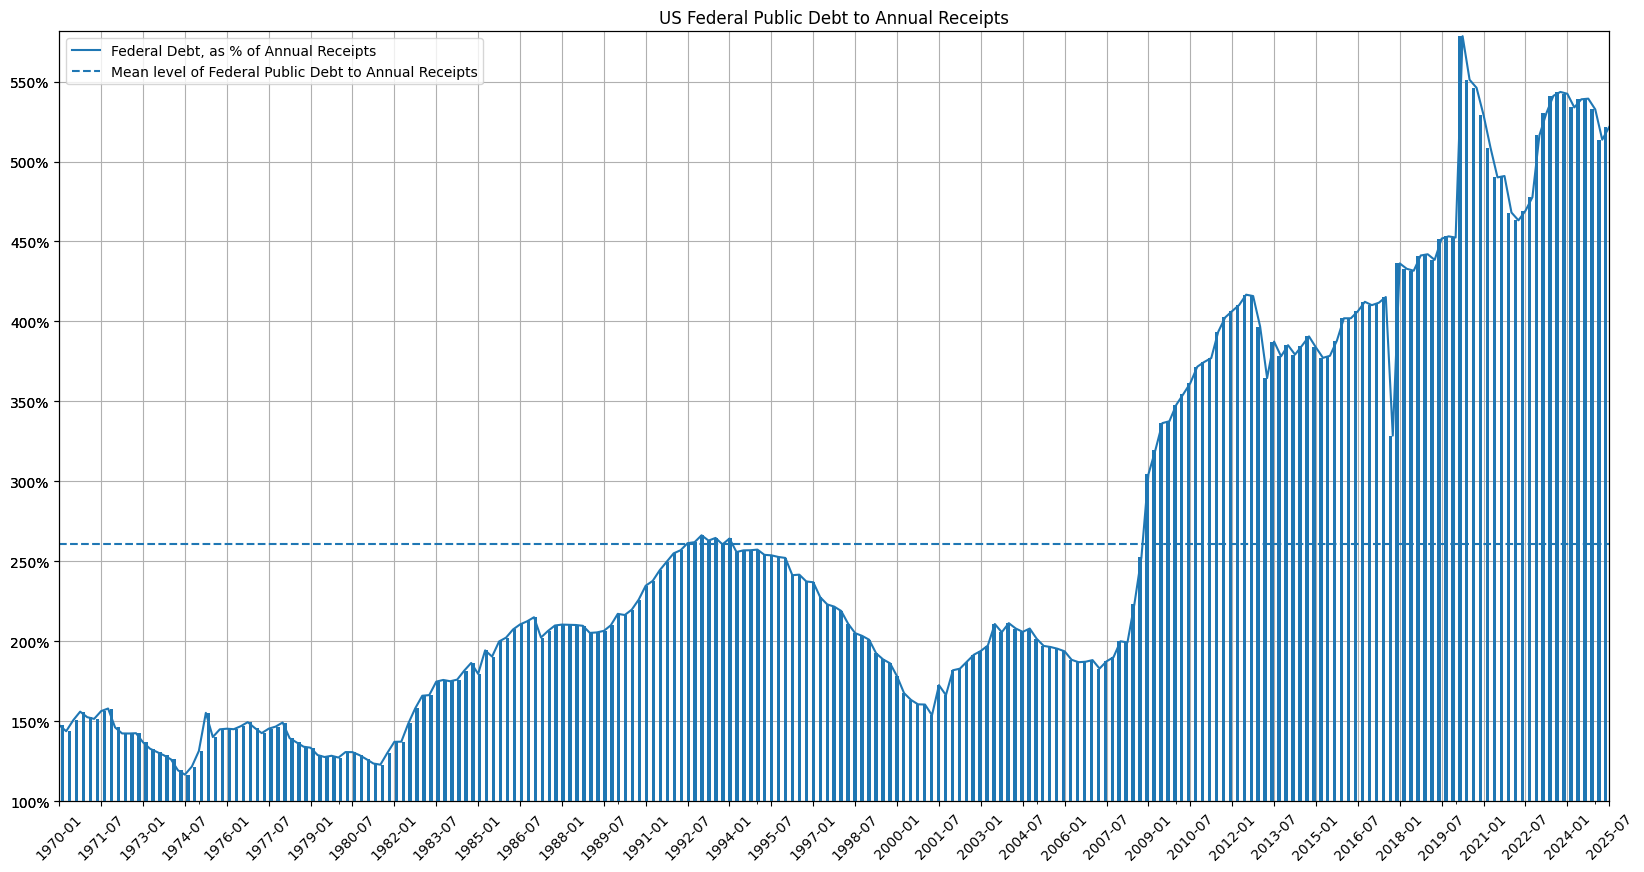

In [17]:
series = fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX].dropna()
ax = series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_1_2, xticks=series.index[::6], xlabel='',
                 rot=45, yticks=np.arange(1, 11, .5), ylim=(1, series.max() + .03))
ax2 = ax.twiny()
series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(series.mean(), c='#1f77b4', ls='--', label=LABEL_DEBT_TO_TAX)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, series.index[::6])))

#### Budget deficit to GDP ratio

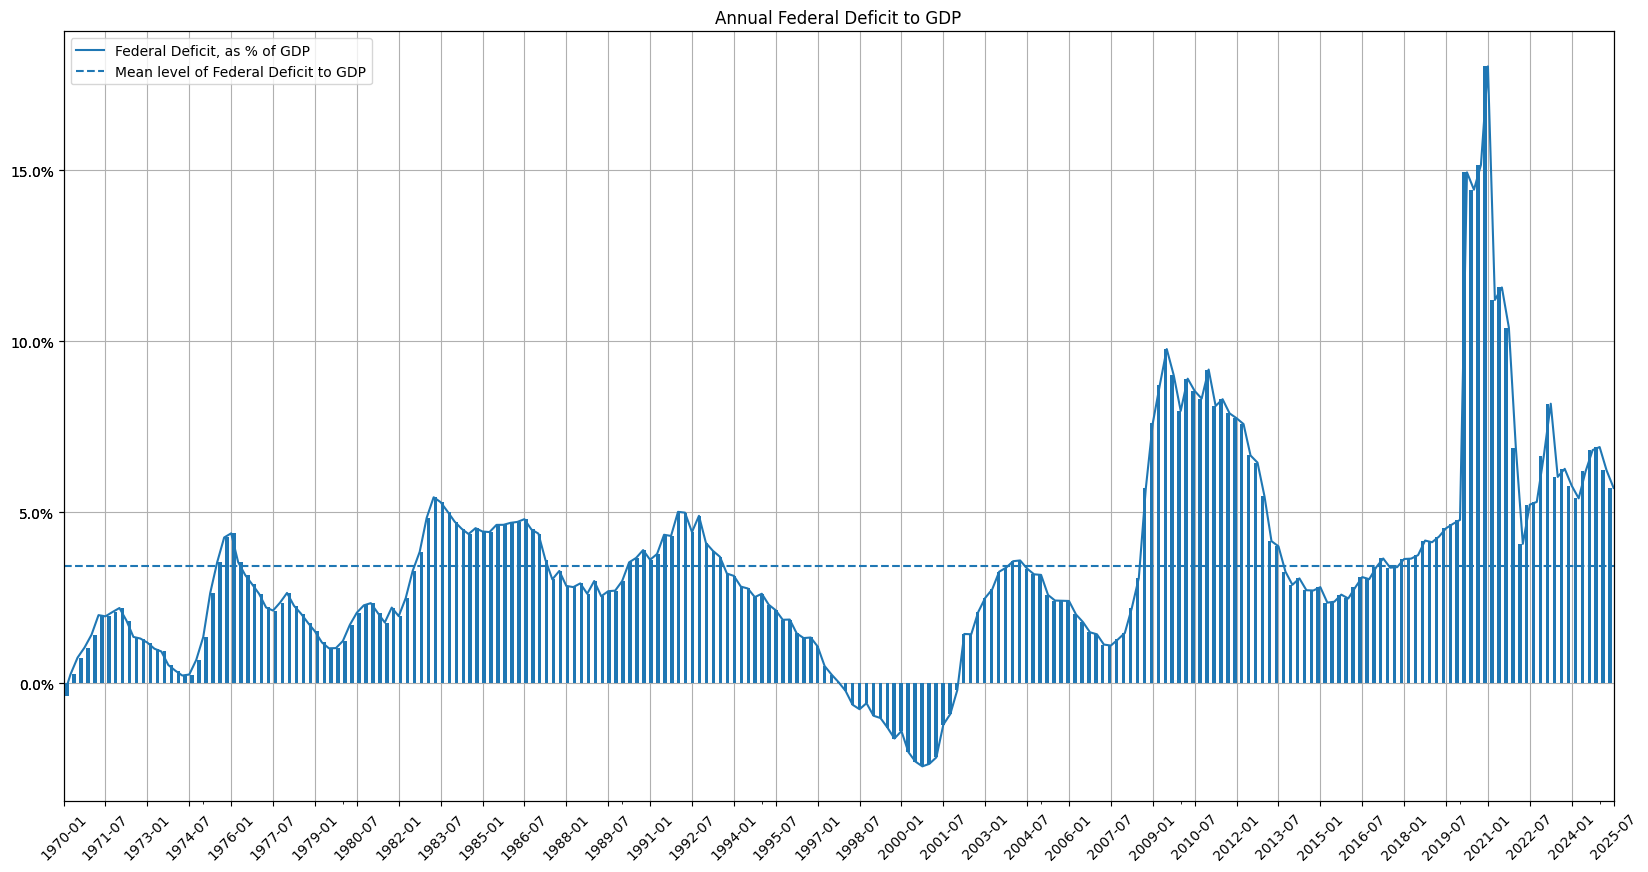

In [18]:
series = fred_pub_debt_and_tax_rev[FEDERAL_DEFICIT_TO_GDP]
ax = series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_4,
                 xticks=series.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=series.mean(), c='#1f77b4', ls='--', label=LABEL_BUDGET_DEFICIT_TO_GDP)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, series.index[::6])))

#### Annual Interest Outlays to GDP and Annual Interest Outlays to Receipts ratios
Annual interest outlays are approaching an all-time high and continue to rise rapidly. However, despite rising debt levels, the ratio of interest outlays to tax revenue remains below its peak in the 1980s.

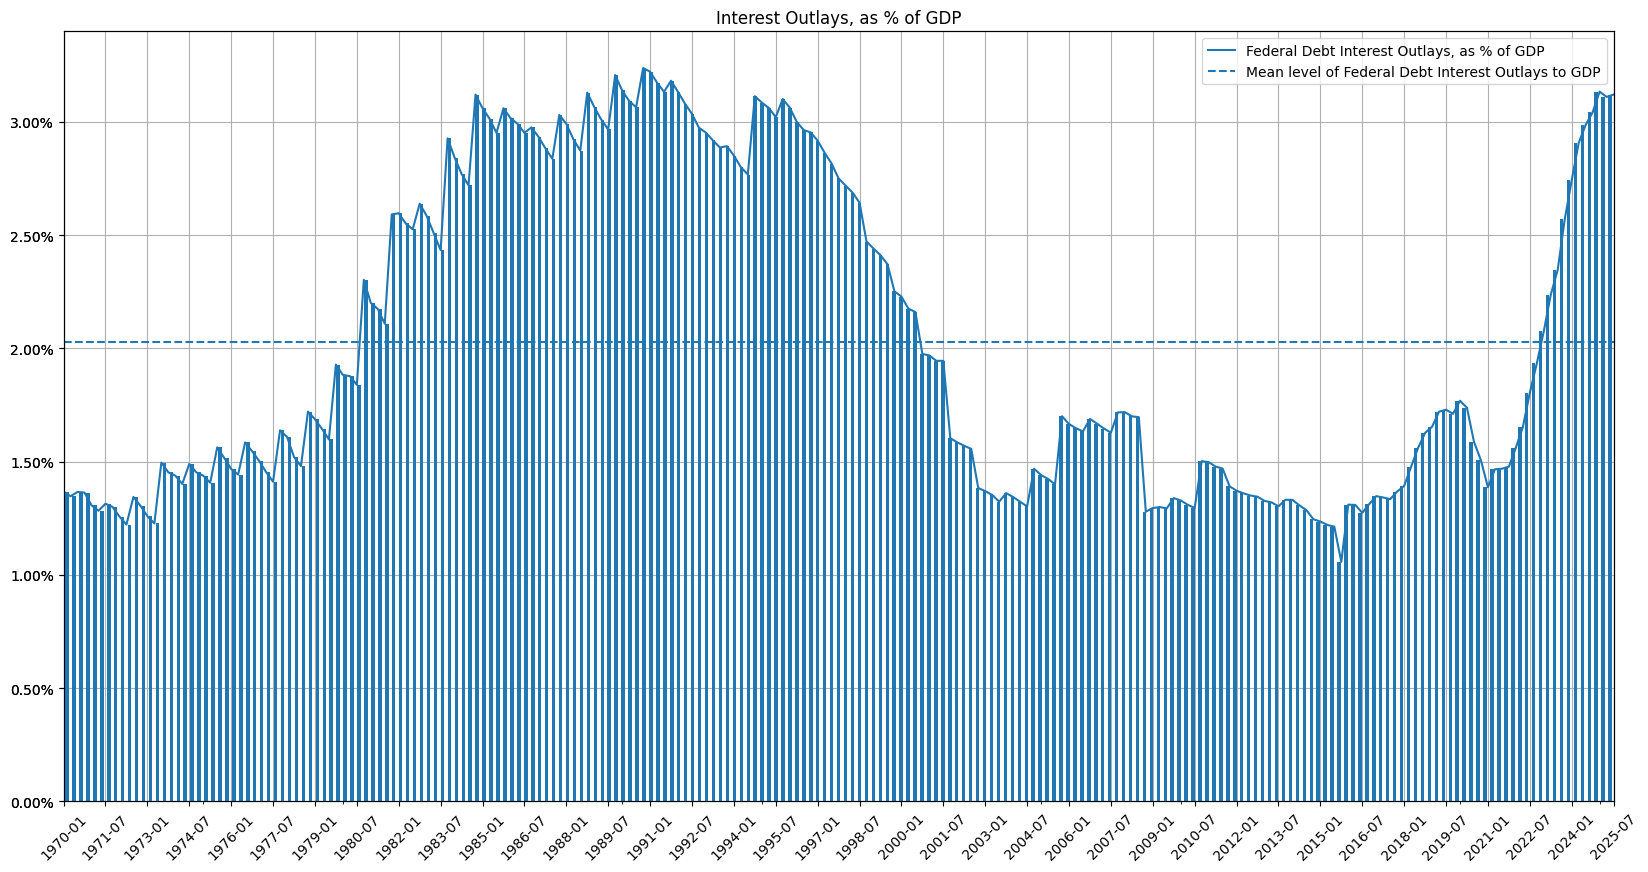

In [19]:
series = fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST_TO_GDP]
ax = series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_3,
                 xticks=series.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=series.mean(), c='#1f77b4', ls='--', label=LABEL_INTEREST_OUTLAYS_TO_GDP)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, series.index[::6])))

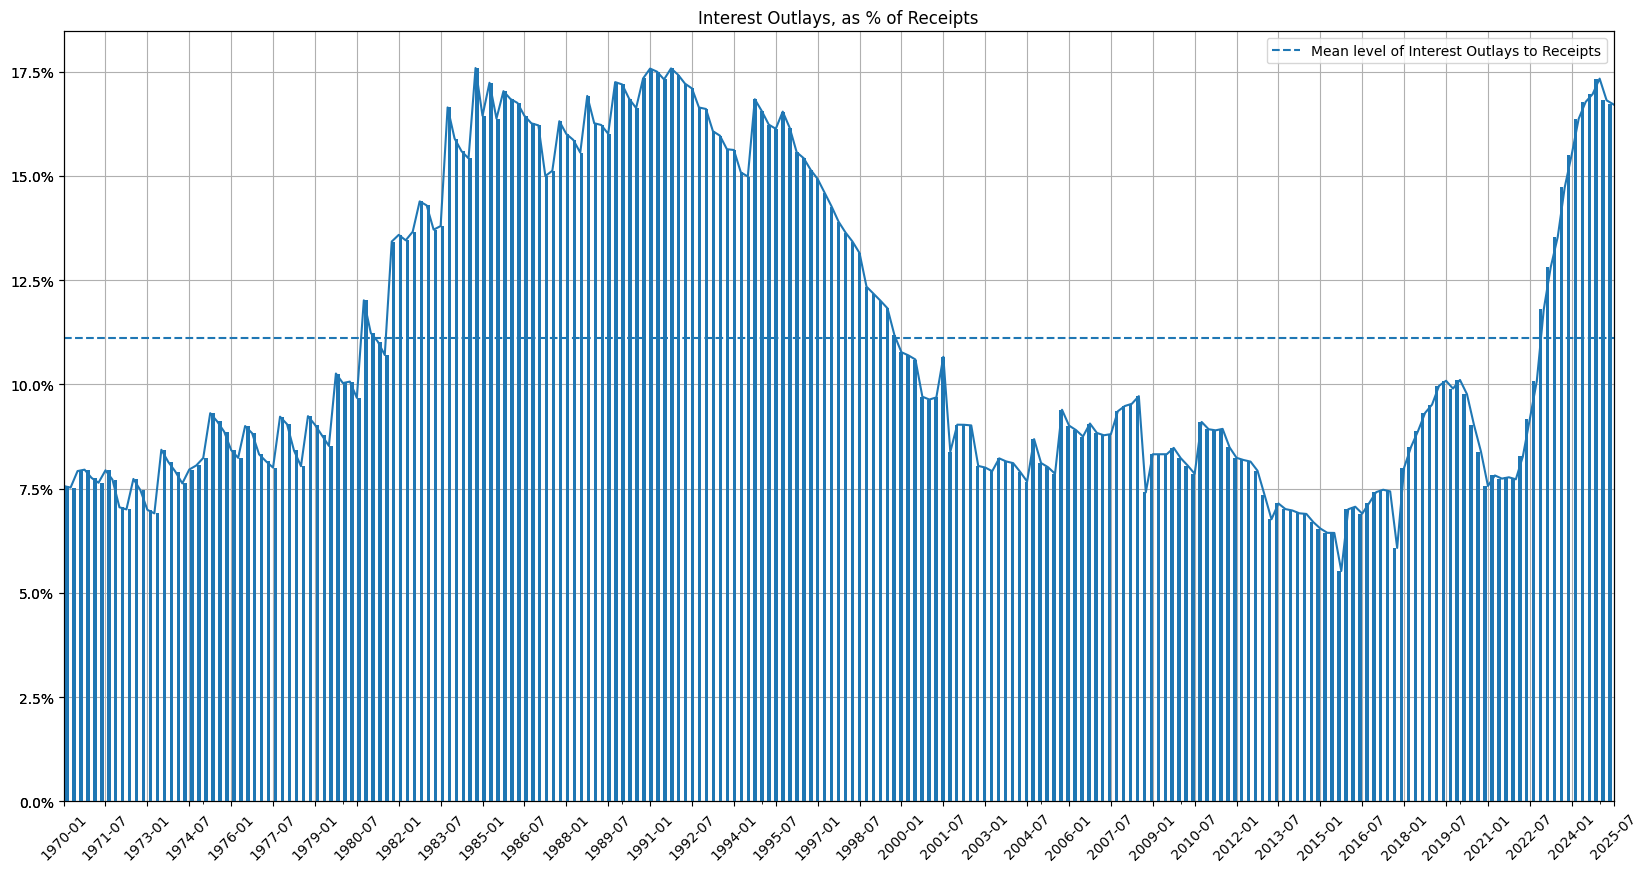

In [20]:
series = fred_pub_debt_and_tax_rev.loc[:, FEDERAL_DEBT_INTEREST] / fred_pub_debt_and_tax_rev.loc[:, FEDERAL_TAX_REVENUE]
share_mean = series.mean()
ax = series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_5,
                 xticks=series.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=share_mean, c='#1f77b4', ls='--', label=LABEL_INT_OUTLAYS_TO_TAX_REV)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, series.index[::6])))

In [21]:
print('Mean level of Federal Debt to GDP: {:.2%}'.format(
    fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_GDP].mean()))
print('Mean level of Federal Debt to Annual Receipts: {:.2%}'.format(
    fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX].mean()))
print('Mean level of Budget Balance as % of GDP: {:.2%}'.format(
    -fred_pub_debt_and_tax_rev[FEDERAL_DEFICIT_TO_GDP].mean()))
print('Mean level of Federal Debt Interest Outlays to GDP: {:.2%}'.format(
    fred_pub_debt_and_tax_rev[FEDERAL_DEBT_INTEREST_TO_GDP].mean()))

Mean level of Federal Debt to GDP: 47.29%
Mean level of Federal Debt to Annual Receipts: 261.02%
Mean level of Budget Balance as % of GDP: -3.43%
Mean level of Federal Debt Interest Outlays to GDP: 2.03%


In [22]:
print('Mean level of Interest Outlays to Receipts: {:.2%}'.format(share_mean.mean()))

Mean level of Interest Outlays to Receipts: 11.11%


#### US Total Federal Public Debt to GDP and Federal Debt to Tax Revenues ratios from 1990 and onwards

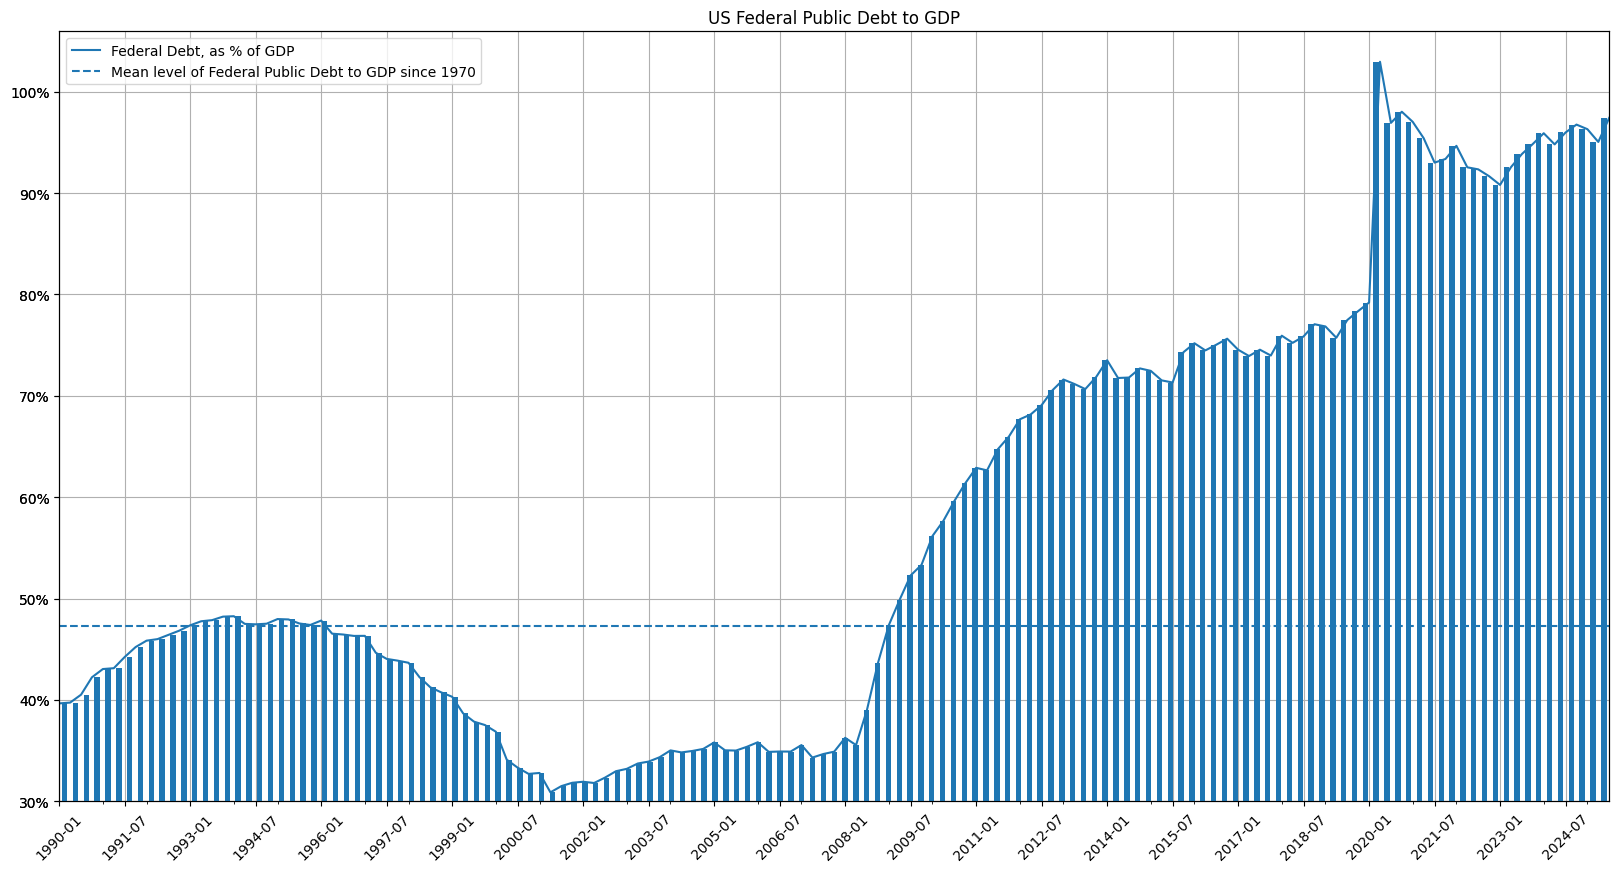

In [23]:
shorter_series = fred_pub_debt_and_tax_rev.loc['1990':, FEDERAL_DEBT_TO_GDP].dropna()
suffix = ' since {:%Y}'.format(fred_pub_debt_and_tax_rev.index[0])
ax = shorter_series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_1_1,
                         xticks=shorter_series.index[::6], xlabel='', rot=45, yticks=np.arange(.3, shorter_series.max() + .03, .1),
                         ylim=(.30, shorter_series.max() + .03))
ax2 = ax.twiny()
shorter_series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_GDP].mean(), c='#1f77b4', ls='--',
           label=LABEL_DEBT_TO_GDP + suffix)
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

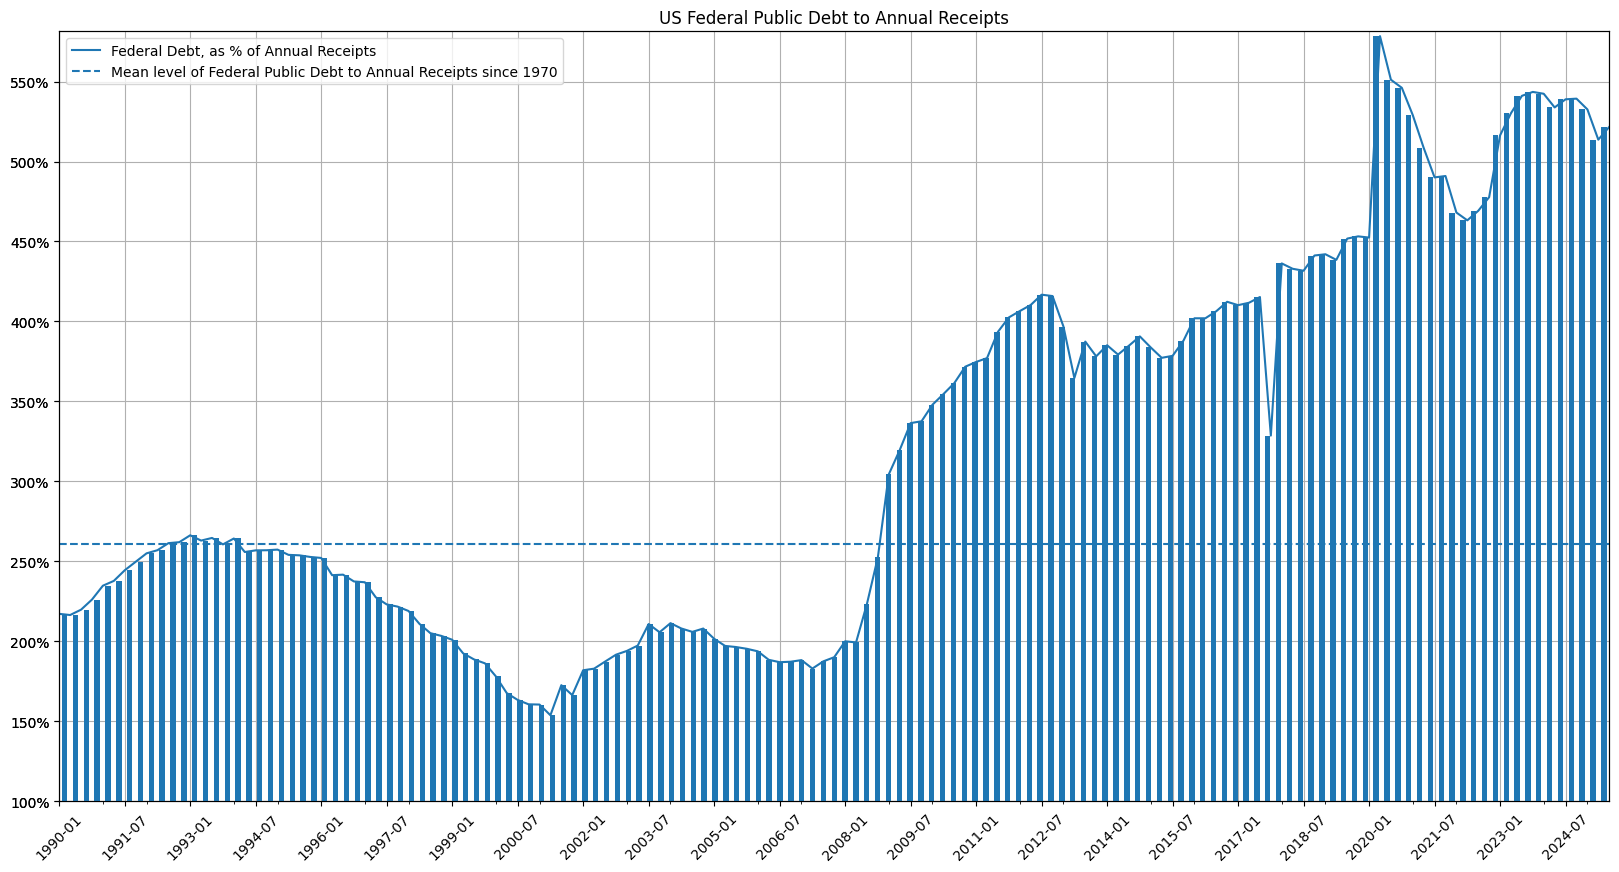

In [24]:
shorter_series = fred_pub_debt_and_tax_rev.loc['1990':, FEDERAL_DEBT_TO_TAX].dropna()
ax = shorter_series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_1_2,
                         xticks=shorter_series.index[::6], xlabel='', rot=45, yticks=np.arange(1, shorter_series.max() + .3, .5),
                         ylim=(1, shorter_series.max() + .03))
ax2 = ax.twiny()
shorter_series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev[FEDERAL_DEBT_TO_TAX].mean(), c='#1f77b4', ls='--',
           label=LABEL_DEBT_TO_TAX + suffix)
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

#### Annual Federal Deficit to GDP, Annual Interest Outlays to GDP, and Annual Interest Outlays to Receipts ratios from 1990 and onwards

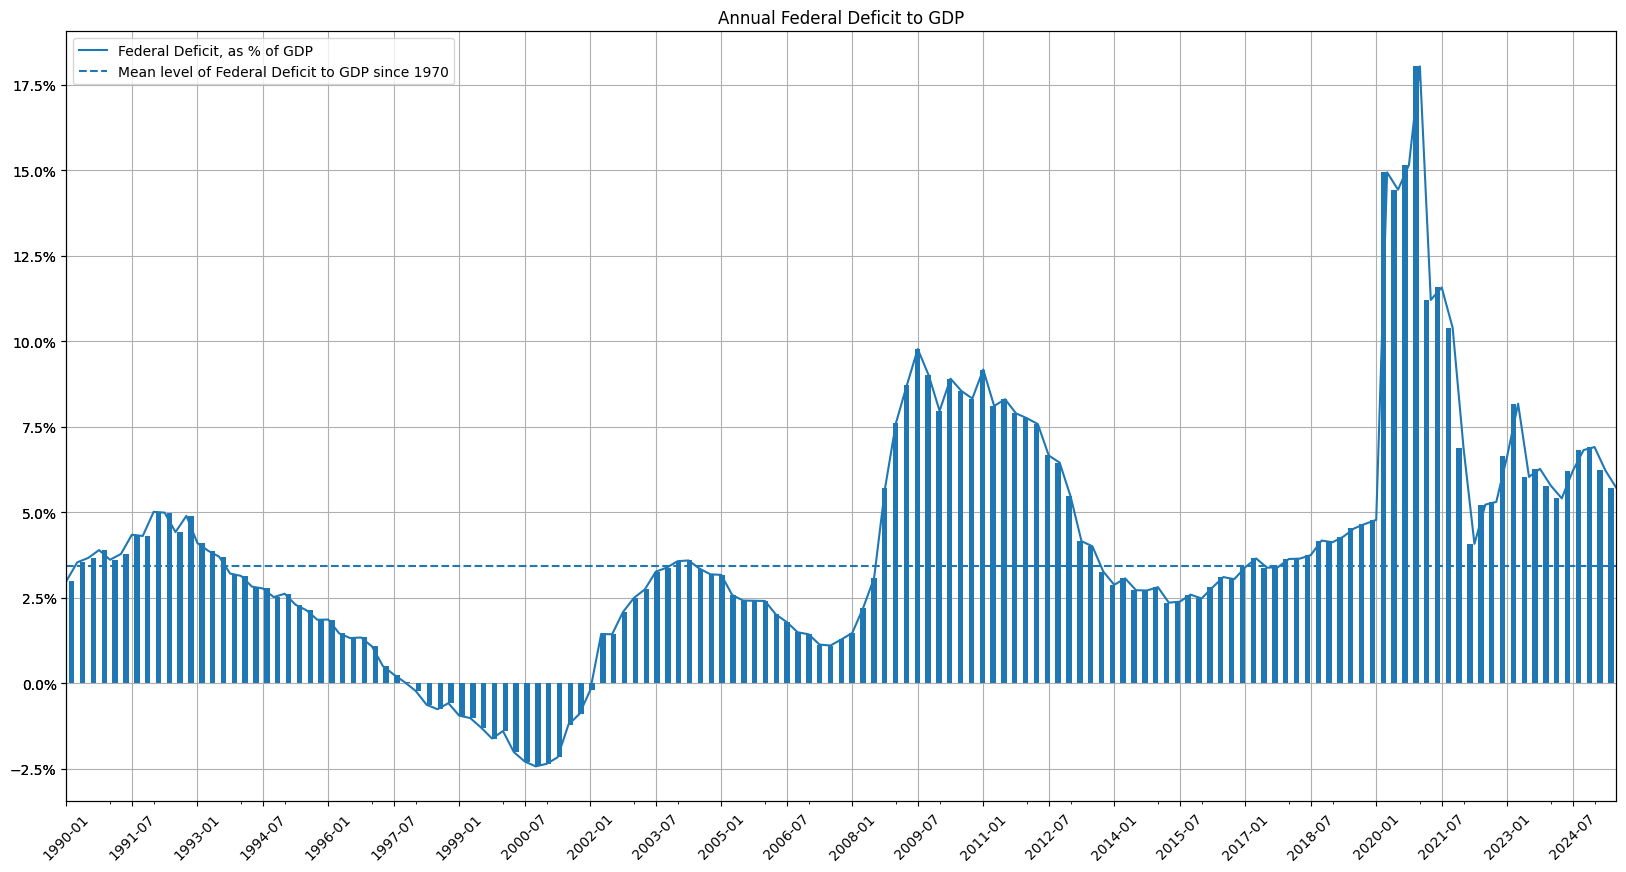

In [25]:
shorter_series = fred_pub_debt_and_tax_rev.loc['1990':, [FEDERAL_DEFICIT_TO_GDP, FEDERAL_DEBT_INTEREST_TO_GDP]]
y_step = .025
y_max = shorter_series.iloc[:,0].max()
y_max += y_step - y_max % y_step
ax = shorter_series.iloc[:,0].plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_4,
                         xticks=shorter_series.index[::6], xlabel='', rot=45,
                         yticks=np.arange(-.025, y_max, y_step))
ax2 = ax.twiny()
shorter_series.iloc[:,0].plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev.loc[:, FEDERAL_DEFICIT_TO_GDP].mean(), c='#1f77b4', ls='--',
           label=LABEL_BUDGET_DEFICIT_TO_GDP + suffix)
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

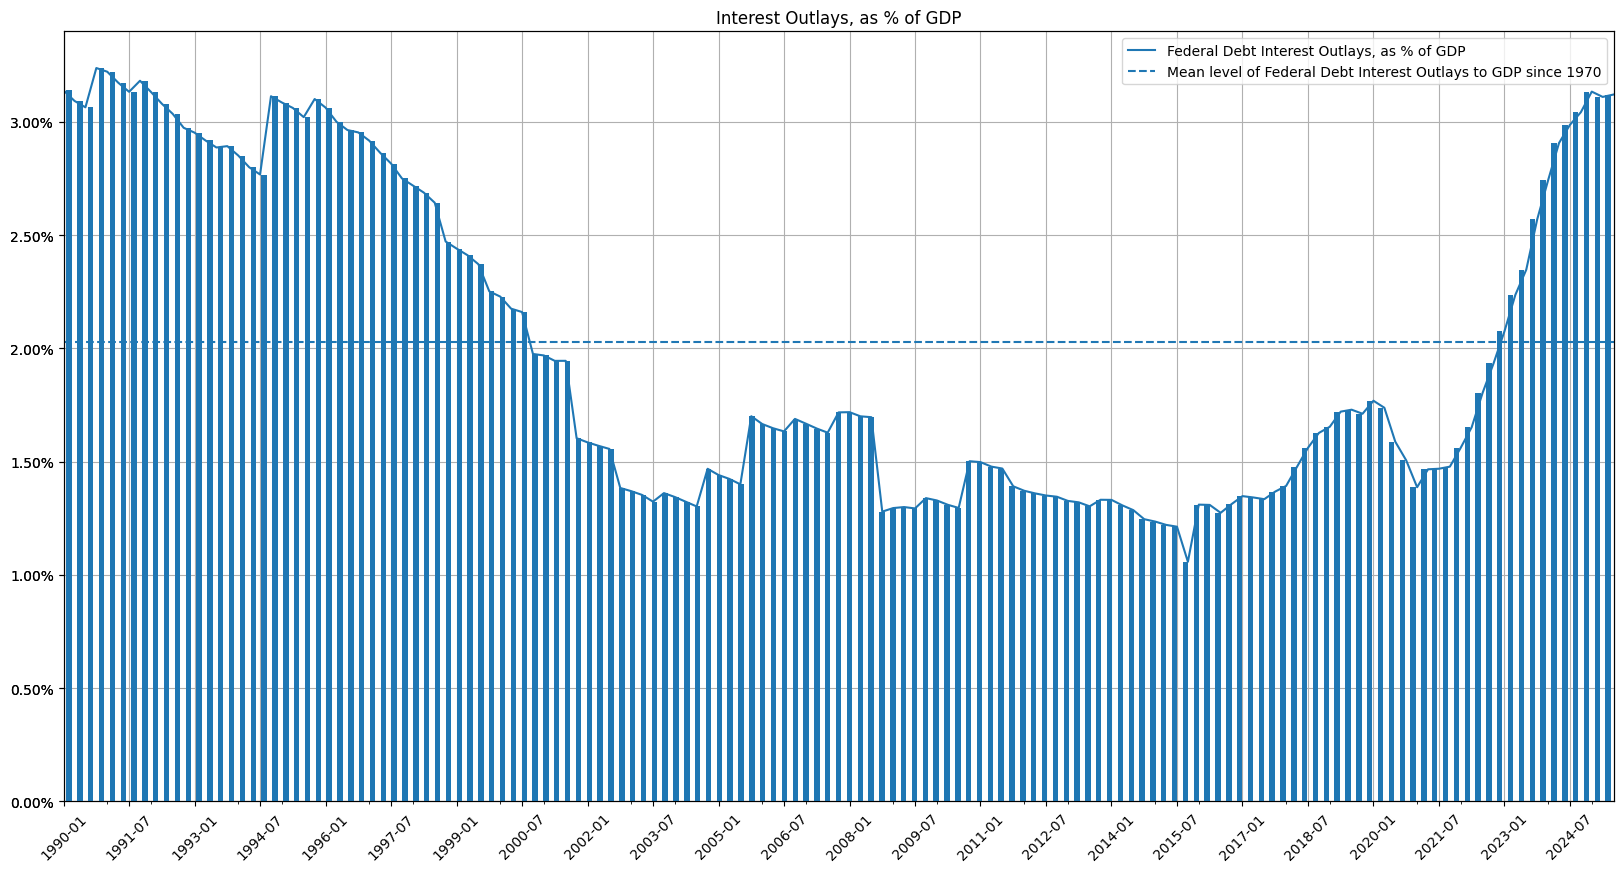

In [26]:
# Unfortunately updated only annually, therefore accurate only for Q3.
ax = shorter_series.iloc[:,1:].plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_3,
                                    linestyle='-', xticks=shorter_series.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
shorter_series.iloc[:,1:].plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=fred_pub_debt_and_tax_rev.loc[:, FEDERAL_DEBT_INTEREST_TO_GDP].mean(), c='#1f77b4', ls='--',
           label=LABEL_INTEREST_OUTLAYS_TO_GDP + suffix)
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

#### Interest outlays on public debt as percentage of Tax Revenues from 1990 and onwards
In addition to looking at Interest Outlays as percentage of GDP, it's also instructive to look at them as percentage of tax revenue.

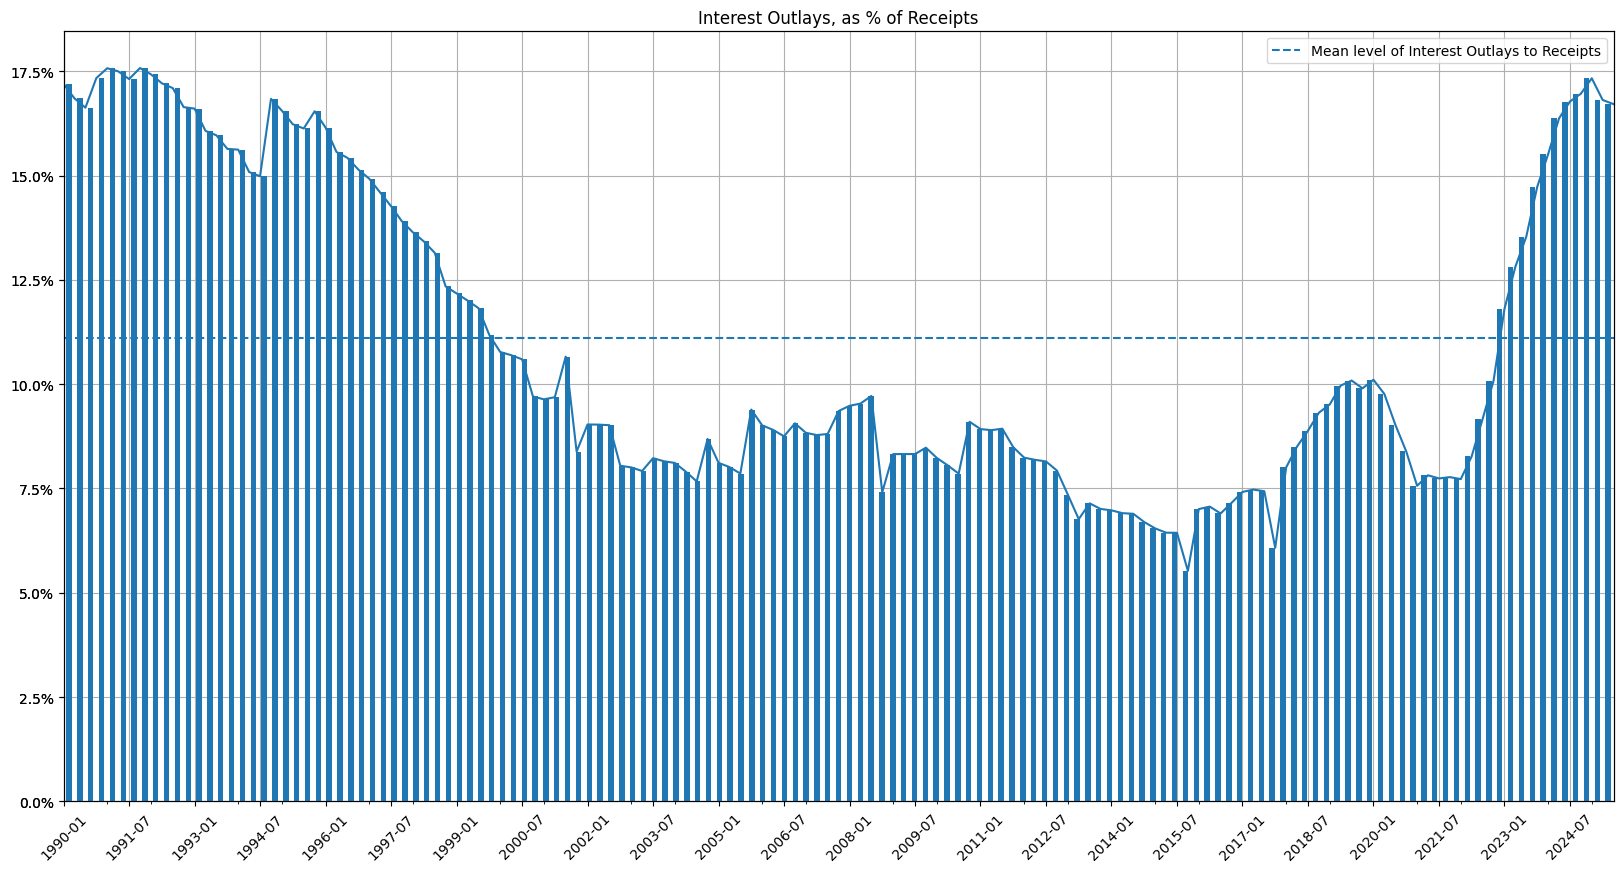

In [27]:
shorter_series = fred_pub_debt_and_tax_rev.loc[:, FEDERAL_DEBT_INTEREST] / fred_pub_debt_and_tax_rev.loc[:, FEDERAL_TAX_REVENUE]
shorter_series = shorter_series.dropna()
share_mean = shorter_series.mean()
shorter_series = shorter_series.loc['1990':]
ax = shorter_series.plot(figsize=(20,10), grid=True, title=DEBT_RATIOS_GRAPH_TITLE_5,
                         xticks=shorter_series.index[::6], xlabel='', rot=45)
ax2 = ax.twiny()
shorter_series.plot.bar(ax=ax2, xlabel='', legend=False)
ax.axhline(y=share_mean, c='#1f77b4', ls='--', label=LABEL_INT_OUTLAYS_TO_TAX_REV)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, shorter_series.index[::6])))

#### Percentage changes in the last quarter

In [28]:
df = fred_pub_debt_and_tax_rev[[FEDERAL_DEBT_TO_GDP, FEDERAL_DEBT_TO_TAX, FEDERAL_DEFICIT_TO_GDP, FEDERAL_DEBT_INTEREST_TO_GDP]]
(df.iloc[-1] - df.iloc[-2]).\
    rename('Changes over quarter starting on %s' % df.index[-1].date()).apply('{:+.4%}'.format)

Federal Debt, as % of GDP                     +2.3800%
Federal Debt, as % of Annual Receipts         +7.9573%
Federal Deficit, as % of GDP                  -0.5096%
Federal Debt Interest Outlays, as % of GDP    +0.0106%
Name: Changes over quarter starting on 2025-07-01, dtype: object

In [29]:
print('US Federal Debt grew by {:+.2f}bn in quarter starting on {:%Y-%m-%d}'
      .format((fred_pub_debt_and_tax_rev.iloc[-1,0]-fred_pub_debt_and_tax_rev.iloc[-2,0])/1000., df.index[-1]))

US Federal Debt grew by +1322.11bn in quarter starting on 2025-07-01


### Federal Debt in current dollar amounts
The majority of statements about the US Federal debt talk about its nominal value, however the recent bout of inflation has been conducive to shrinking its real value. In the below part of the notebook I look at the evolution of US Federal Debt using the current dollar amounts. I use the GDP Implicit Price Deflator to obtain past real values of the Federal Debt. This is similar to how real GDP is calculated.

I make use of the following dataseries provided by [FRED](https://fred.stlouisfed.org)
* `GDPDEF` &mdash; Gross Domestic Product: Implicit Price Deflator (quarterly frequency, seasonally adjusted).

In [30]:
real_pub_debt = pd.concat([fred_pub_debt_and_tax_rev.iloc[:,0],
                          (fred_pub_debt_and_tax_rev.iloc[:,0] * nom_2_real_conv_factors).dropna()], axis=1).dropna()
real_pub_debt.rename(columns= {0: 'Real ' + FEDERAL_DEBT}, inplace=True)

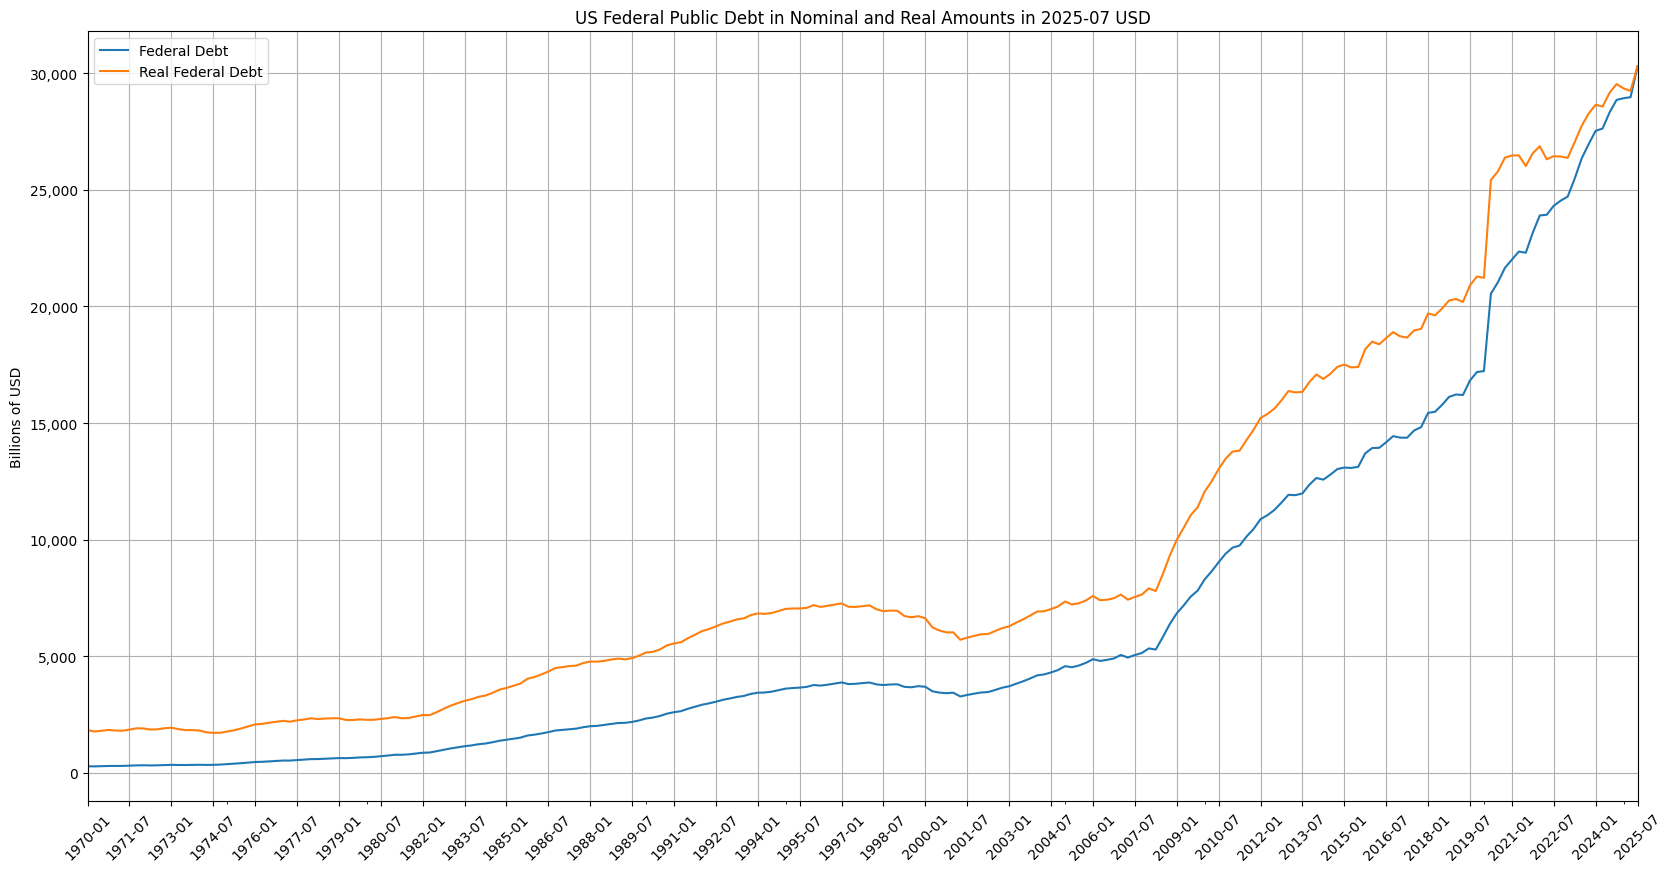

In [31]:
ax = real_pub_debt.plot(figsize=(20,10), grid=True,
    title=FEDERAL_DEBT_IN_REAL_VALUES + IN_USD_FORMATER.format(nom_2_real_conv_factors.index[-1].date()),
    xticks=real_pub_debt.index[::6], xlabel='', rot=45, ylabel=LEFT_Y_AXIS_LABEL)
#                        yticks=np.arange(0, 150, 12.5))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_pub_debt.index[::6])))

#### Zooming in on 1990 and onwards

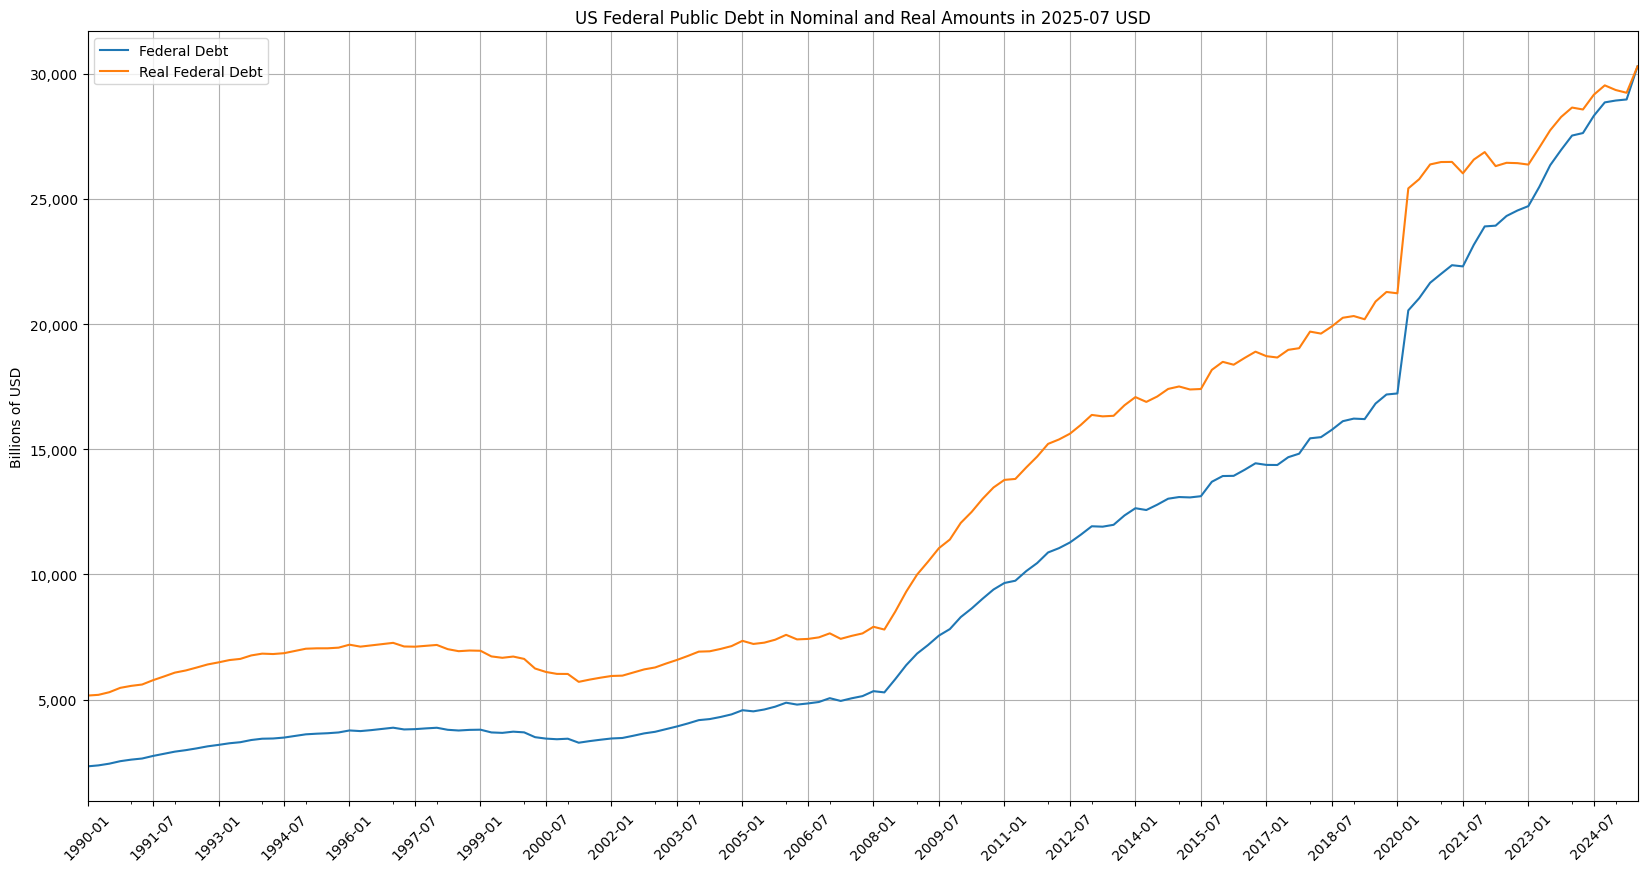

In [32]:
real_pub_debt_from_1990 = real_pub_debt.loc['1990':]
ax = real_pub_debt_from_1990.plot(figsize=(20,10), grid=True,
    title=FEDERAL_DEBT_IN_REAL_VALUES + IN_USD_FORMATER.format(nom_2_real_conv_factors.index[-1].date()),
    xticks=real_pub_debt_from_1990.index[::6], xlabel='', rot=45, ylabel=LEFT_Y_AXIS_LABEL)
#                        yticks=np.arange(0, 150, 12.5))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_pub_debt_from_1990.index[::6])))

#### Zooming in on 2008 and onwards

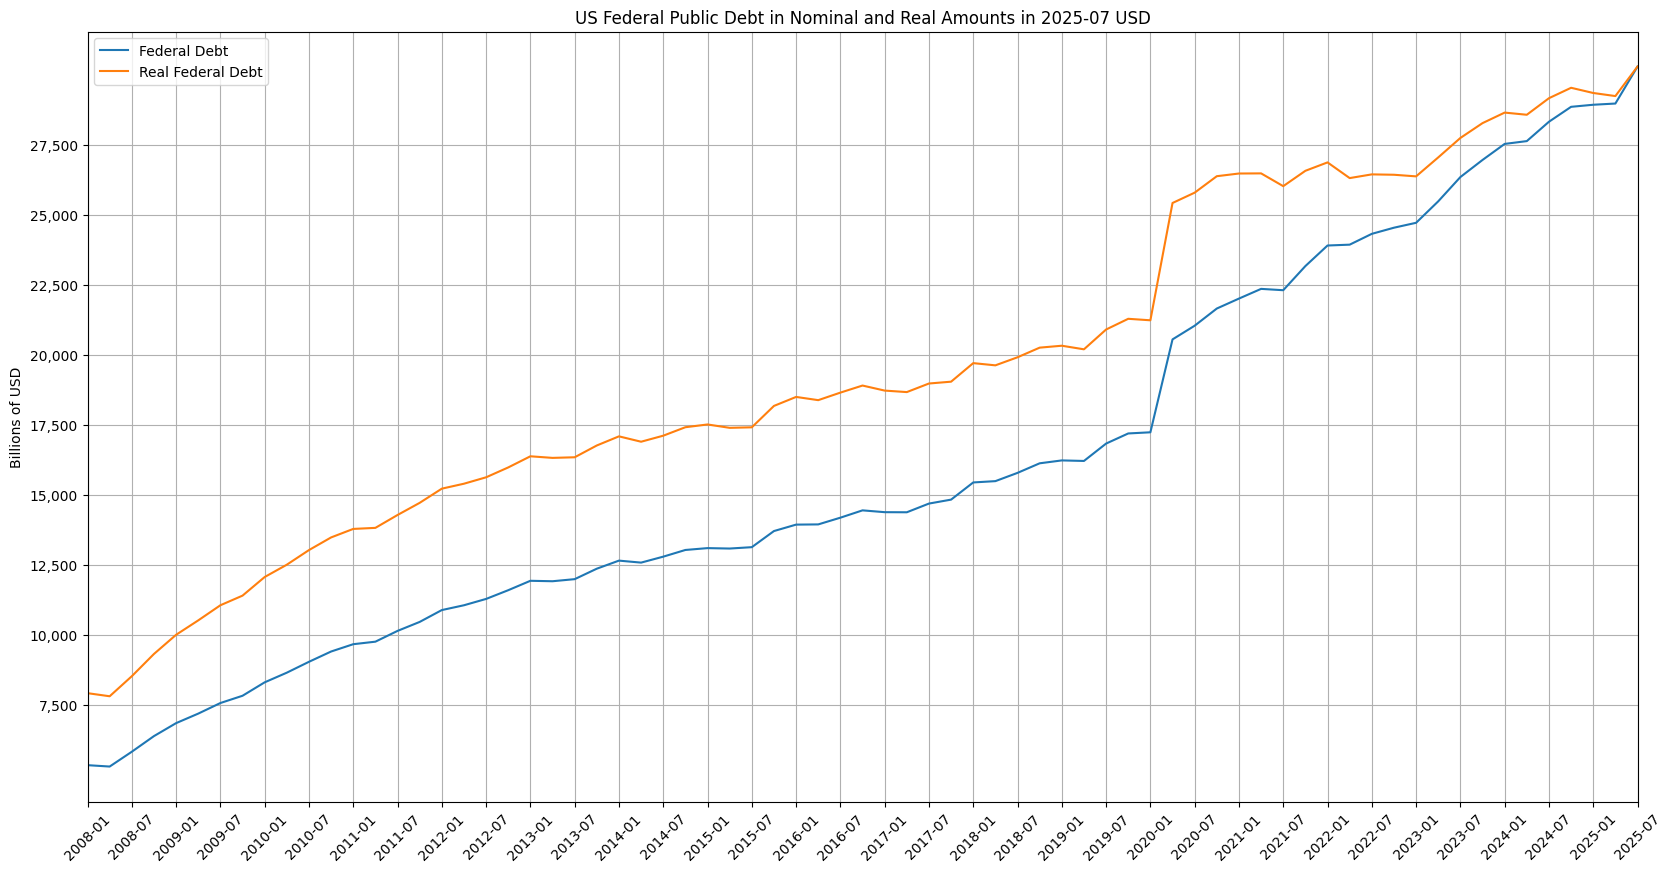

In [33]:
real_pub_debt_from_2008 = real_pub_debt.loc['2008':]
ax = real_pub_debt_from_2008.plot(figsize=(20,10), grid=True,
    title=FEDERAL_DEBT_IN_REAL_VALUES + IN_USD_FORMATER.format(nom_2_real_conv_factors.index[-1].date()),
    xticks=real_pub_debt_from_2008.index[::2], xlabel='', rot=45, ylabel=LEFT_Y_AXIS_LABEL,
    yticks=np.arange(7.5e6, 29e6, 2.5e6))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1000)))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, real_pub_debt_from_2008.index[::2])))

In [34]:
print('Nominal US Federal Public Debt changed by {:+.2f}bn in quarter starting on {:%Y-%m-%d}'
      .format((real_pub_debt_from_2008.iloc[-1,0]-real_pub_debt_from_2008.iloc[-2,0]) / 1000,
              real_pub_debt_from_2008.index[-1]))
print('Real US Federal Public Debt changed by {:+.2f}bn in quarter starting on {:%Y-%m-%d}'
      .format((real_pub_debt_from_2008.iloc[-1,1]-real_pub_debt_from_2008.iloc[-2,1]) / 1000,
              real_pub_debt_from_2008.index[-1]))

Nominal US Federal Public Debt changed by +1322.11bn in quarter starting on 2025-07-01
Real US Federal Public Debt changed by +1055.05bn in quarter starting on 2025-07-01
